# Imports

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

EMAIL_USERNAME = "sudershan.sarraf"

# Kernal Estimation

Loading and preprocessing images...


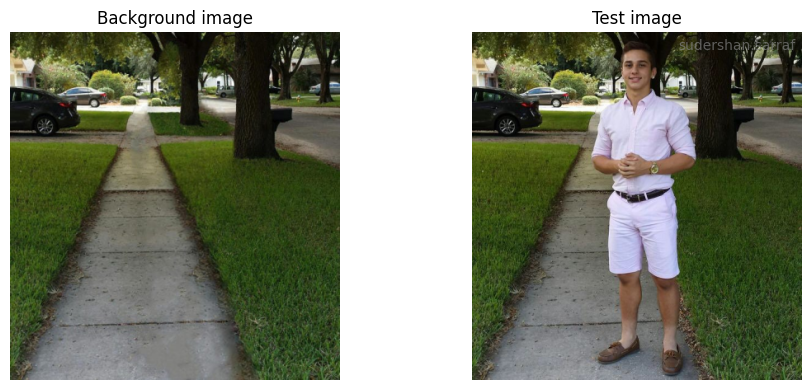


=== Kernel: gaussian ===
KDE fitted: kernel=gaussian, bandwidth=0.07, samples=25000, dim=3
Predicting densities for test image...


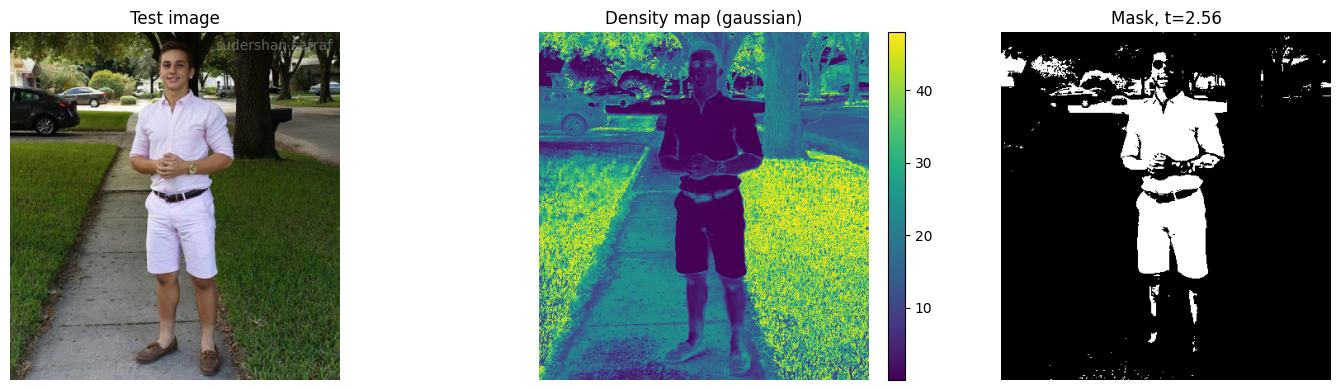

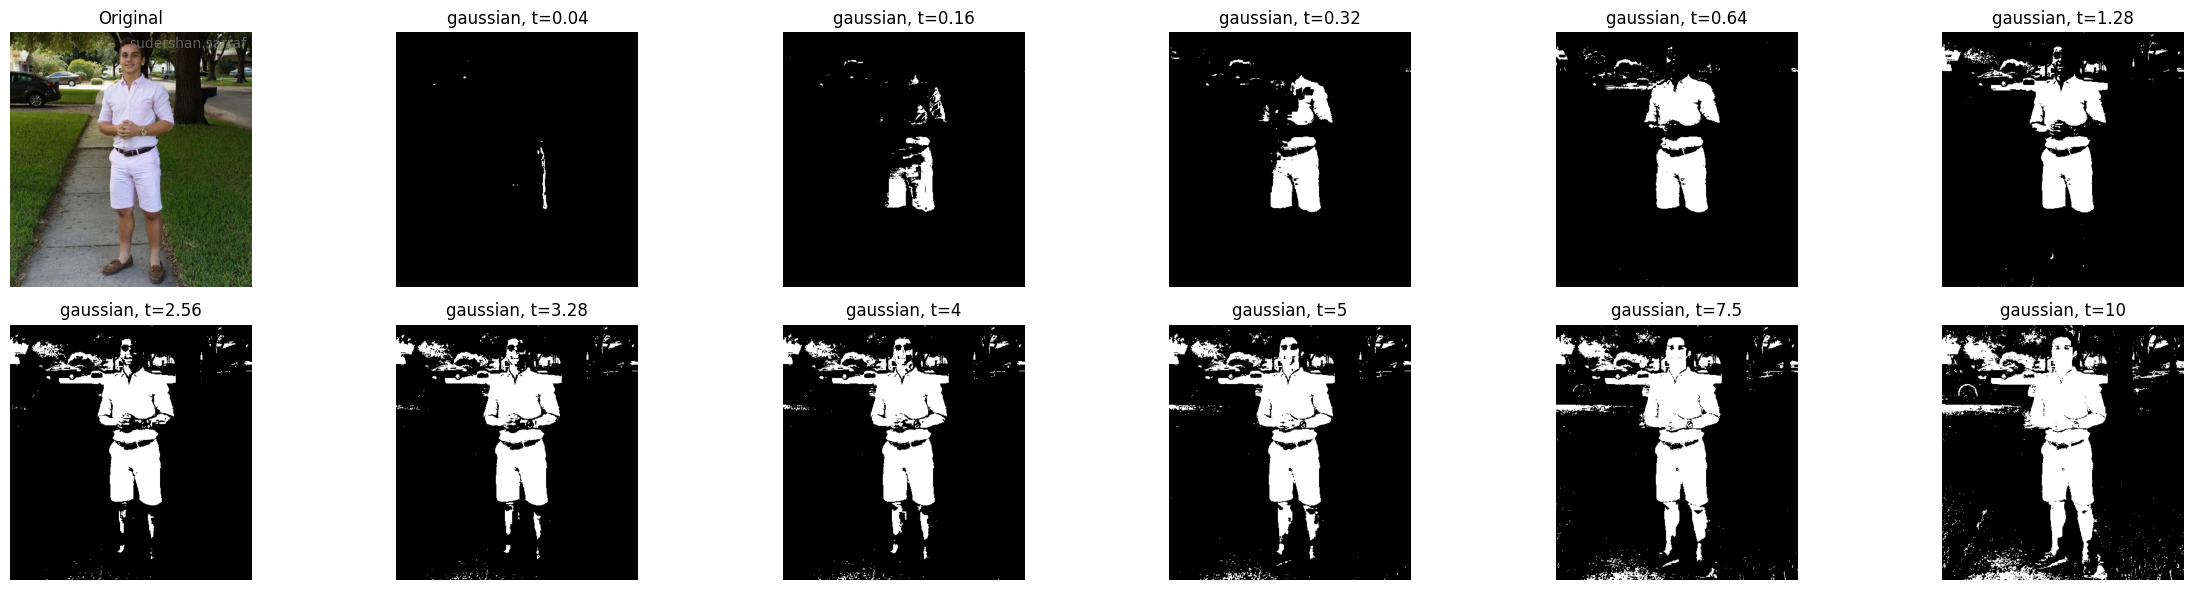


=== Kernel: uniform ===
KDE fitted: kernel=uniform, bandwidth=0.07, samples=25000, dim=3
Predicting densities for test image...


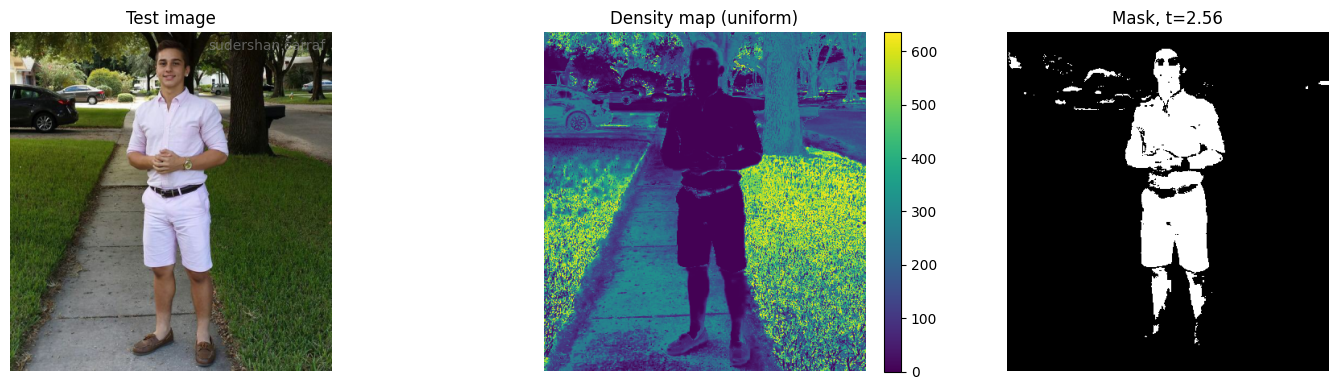

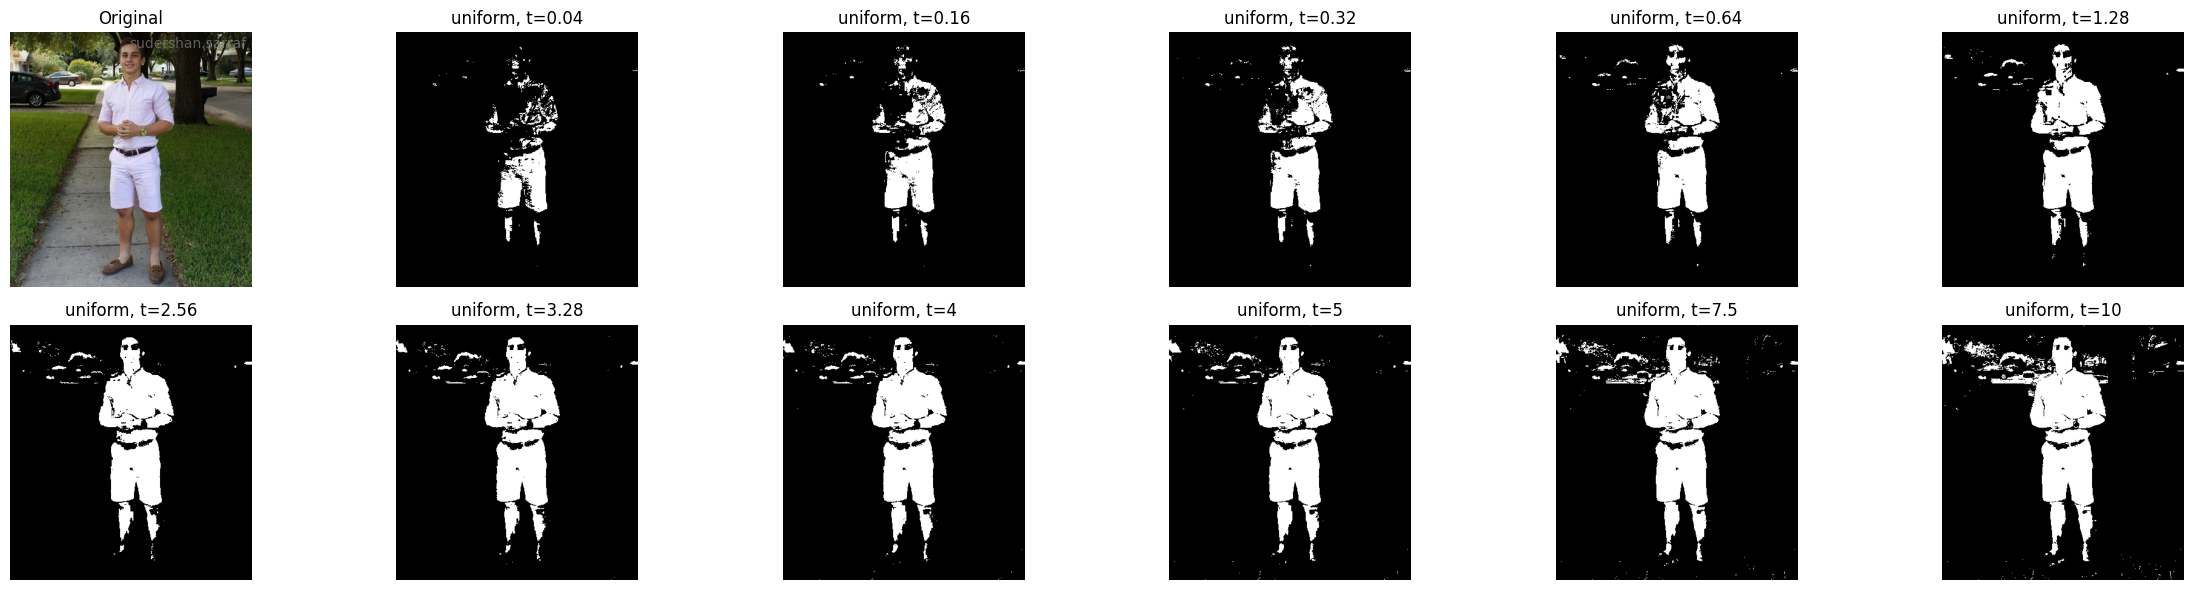


=== Kernel: triangular ===
KDE fitted: kernel=triangular, bandwidth=0.07, samples=25000, dim=3
Predicting densities for test image...


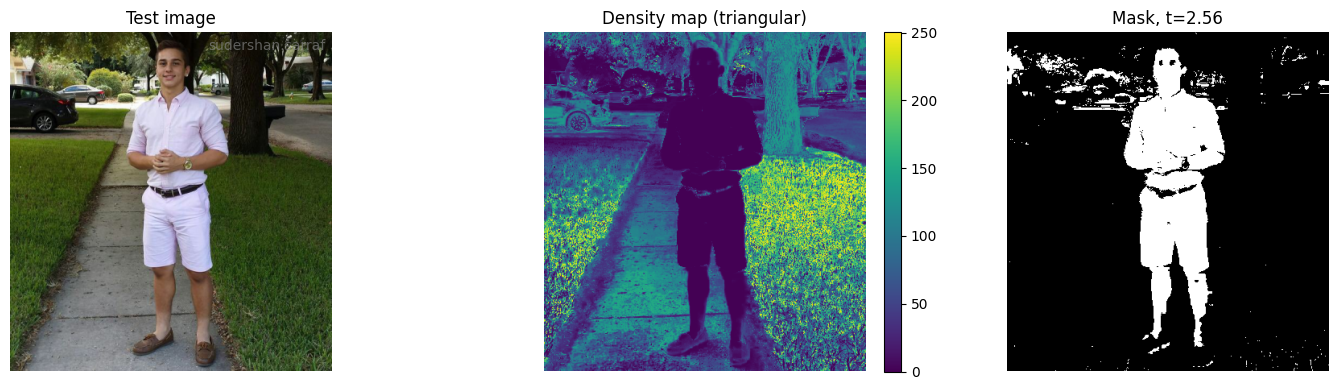

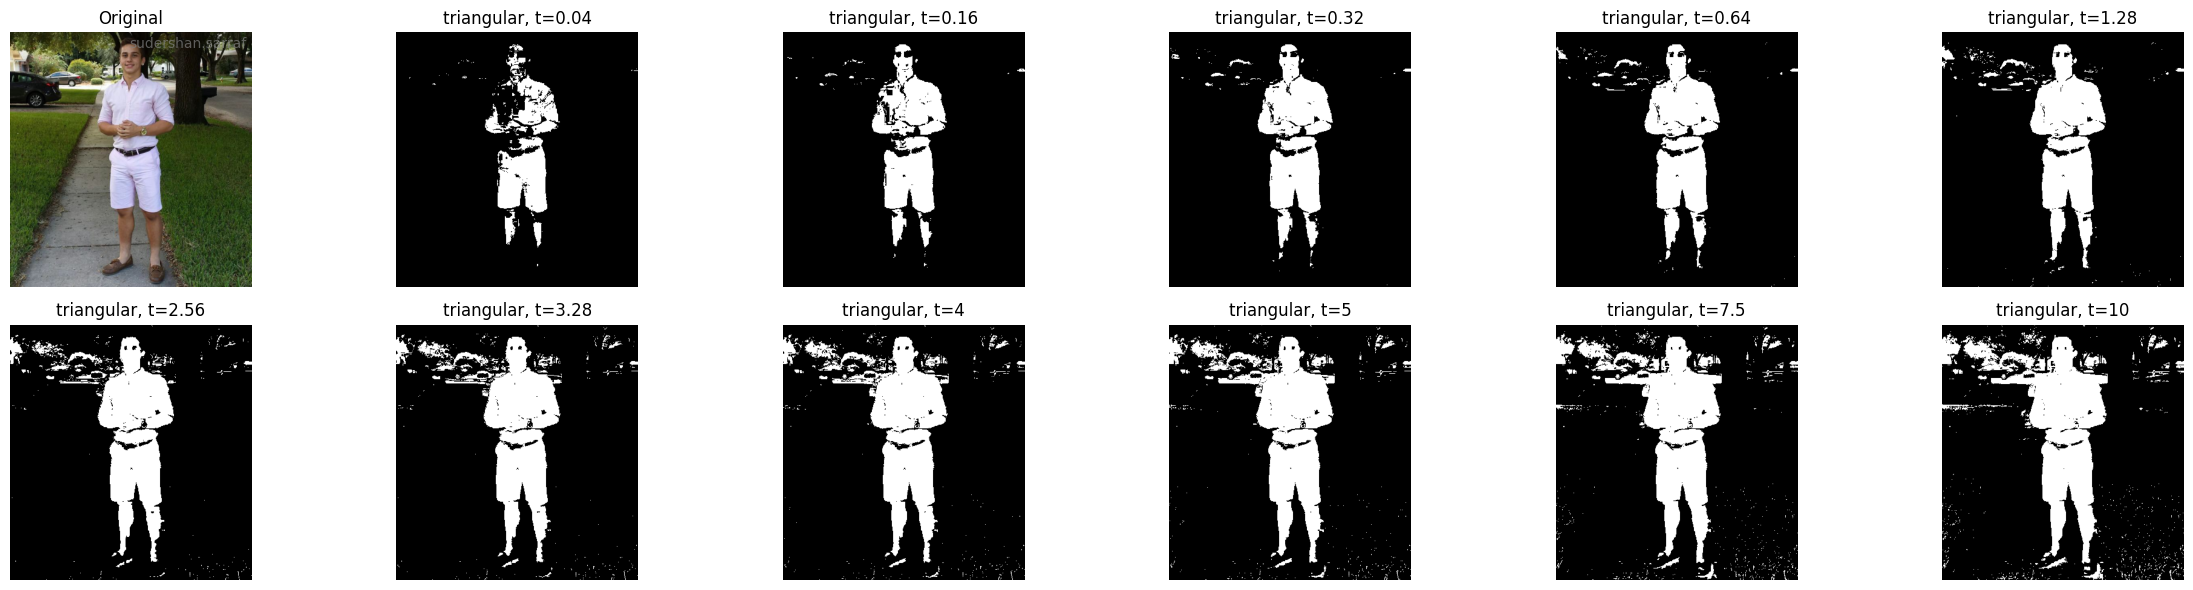

In [14]:
if "EMAIL_USERNAME" not in globals():
    EMAIL_USERNAME = "sudershan.sarraf"

if "add_username_to_plot" not in globals():
    def add_username_to_plot(ax, username):
        ax.text(
            0.98, 0.98,
            username,
            ha='right', va='top',
            transform=ax.transAxes,
            fontsize=10, color='gray', alpha=0.7
        )

def maybe_add_username(ax):
    if "EMAIL_USERNAME" in globals() and "add_username_to_plot" in globals():
        add_username_to_plot(ax, EMAIL_USERNAME)


def load_and_prep_images(bg_path, test_path, width=400):
    bg_image = cv2.imread(bg_path)
    bg_image = cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB)

    test_image = cv2.imread(test_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = bg_image.shape[:2]
    aspect_ratio = orig_h / orig_w
    height = int(width * aspect_ratio)

    bg_image_resized = cv2.resize(bg_image, (width, height), interpolation=cv2.INTER_AREA)
    test_image_resized = cv2.resize(test_image, (width, height), interpolation=cv2.INTER_AREA)

    bg_features = bg_image_resized.reshape(-1, 3).astype(np.float32) / 255.0
    test_features = test_image_resized.reshape(-1, 3).astype(np.float32) / 255.0

    return bg_image_resized, test_image_resized, bg_features, test_features


class KDE:
    def __init__(self, kernel="gaussian", bandwidth=0.1):
        kernel = kernel.lower()
        if kernel not in ("gaussian", "uniform", "triangular"):
            raise ValueError("kernel must be 'gaussian', 'uniform', or 'triangular'")
        self.kernel = kernel
        self.bandwidth = float(bandwidth)
        self.training_data = None
        self.n = 0
        self.d = 0
        self.norm_const = 1.0

    def fit(self, data, sample_size=10000):
        data = np.asarray(data, dtype=np.float32)
        n_full, self.d = data.shape

        if n_full > sample_size:
            idx = np.random.choice(n_full, sample_size, replace=False)
            self.training_data = data[idx]
            self.n = sample_size
        else:
            self.training_data = data
            self.n = n_full

        if self.kernel == "gaussian":
            self.norm_const = 1.0 / ((2.0 * np.pi) ** (self.d / 2.0))
        else:
            self.norm_const = 1.0

        print(f"KDE fitted: kernel={self.kernel}, bandwidth={self.bandwidth}, samples={self.n}, dim={self.d}")

    def _kernel_values(self, u_sq_norm):
        if self.kernel == "gaussian":
            return self.norm_const * np.exp(-0.5 * u_sq_norm)
        elif self.kernel == "uniform":
            return (u_sq_norm <= 1.0).astype(np.float32)
        elif self.kernel == "triangular":
            r = np.sqrt(u_sq_norm)
            return np.clip(1.0 - r, 0.0, None).astype(np.float32)
        else:
            raise RuntimeError("Unknown kernel")

    def _kernel_density_batch(self, samples_batch):
        if self.training_data is None:
            raise RuntimeError("Must call fit() before predict().")

        s_batch = samples_batch[:, np.newaxis, :]
        t_data = self.training_data[np.newaxis, :, :]

        u = (s_batch - t_data) / self.bandwidth
        u_sq_norm = np.sum(u ** 2, axis=2)

        kernel_vals = self._kernel_values(u_sq_norm)
        sum_of_kernels = np.sum(kernel_vals, axis=1)
        scaling_factor = 1.0 / (self.n * (self.bandwidth ** self.d))
        densities = scaling_factor * sum_of_kernels
        return densities

    def predict(self, samples, batch_size=500):
        samples = np.asarray(samples, dtype=np.float32)
        n_samples = samples.shape[0]
        densities = np.zeros(n_samples, dtype=np.float32)

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch = samples[start:end]
            densities[start:end] = self._kernel_density_batch(batch)

        return densities


def main_q1():
    BACKGROUND_IMG_PATH = "data/1/back.jpg"
    TEST_IMG_PATH = "data/1/Full.jpg"

    RESIZE_WIDTH = 400
    KDE_SAMPLE_SIZE = 25000
    KDE_BANDWIDTH = 0.07

    # thresholds now start at 0.01 and keep increasing
    THRESHOLDS = [0.04, 0.16, 0.32, 0.64, 1.28, 2.56, 3.28, 4.0, 5.0, 7.5, 10]

    print("Loading and preprocessing images...")
    bg_img, test_img, bg_features, test_features = load_and_prep_images(
        BACKGROUND_IMG_PATH, TEST_IMG_PATH, width=RESIZE_WIDTH
    )

    H, W, _ = test_img.shape

    fig0, axes0 = plt.subplots(1, 2, figsize=(10, 4))
    axes0[0].imshow(bg_img)
    axes0[0].set_title("Background image")
    axes0[0].axis("off")

    axes0[1].imshow(test_img)
    axes0[1].set_title("Test image")
    axes0[1].axis("off")
    maybe_add_username(axes0[1])
    plt.tight_layout()
    plt.show()

    kernels = ["gaussian", "uniform", "triangular"]

    for kernel_name in kernels:
        print(f"\n=== Kernel: {kernel_name} ===")
        kde = KDE(kernel=kernel_name, bandwidth=KDE_BANDWIDTH)
        kde.fit(bg_features, sample_size=KDE_SAMPLE_SIZE)

        print("Predicting densities for test image...")
        densities = kde.predict(test_features, batch_size=2000)
        density_map = densities.reshape(H, W)

        default_thresh = THRESHOLDS[len(THRESHOLDS) // 2]
        mask_default = (density_map < default_thresh).astype(np.uint8) * 255

        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        axes[0].imshow(test_img)
        axes[0].set_title("Test image")
        axes[0].axis("off")

        im1 = axes[1].imshow(density_map, cmap="viridis")
        axes[1].set_title(f"Density map ({kernel_name})")
        axes[1].axis("off")
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        axes[2].imshow(mask_default, cmap="gray")
        axes[2].set_title(f"Mask, t={default_thresh:g}")
        axes[2].axis("off")

        maybe_add_username(axes[0])
        plt.tight_layout()
        plt.show()

        # grid: 2 rows, masks for multiple thresholds
        n_thresh = len(THRESHOLDS)
        n_panels = n_thresh + 1  # +1 for original image
        n_cols = int(np.ceil(n_panels / 2))

        fig_grid, axes_grid = plt.subplots(2, n_cols, figsize=(4 * n_cols, 6))
        axes_grid = np.array(axes_grid).reshape(2, n_cols)

        axes_grid[0, 0].imshow(test_img)
        axes_grid[0, 0].set_title("Original")
        axes_grid[0, 0].axis("off")

        for j, thr in enumerate(THRESHOLDS):
            mask = (density_map < thr).astype(np.uint8) * 255
            panel_idx = j + 1
            row = panel_idx // n_cols
            col = panel_idx % n_cols
            axes_grid[row, col].imshow(mask, cmap="gray")
            axes_grid[row, col].set_title(f"{kernel_name}, t={thr:g}")
            axes_grid[row, col].axis("off")

        for panel_idx in range(n_panels, 2 * n_cols):
            row = panel_idx // n_cols
            col = panel_idx % n_cols
            axes_grid[row, col].axis("off")

        maybe_add_username(axes_grid[0, 0])
        plt.tight_layout()
        plt.show()


main_q1()


# Observations

### 1.1: Justification for Preprocessing and Features

* **Image Alignment:** I resized both images to a 400px width. This is important
  to make them the same size for comparison and to speed up the calculation.
  Using the full-size images would make the `predict` step take way too long.

* **Feature Representation:** I used the (R, G, B) values for each pixel, normalized
  to be between 0 and 1. This is my 3-dimensional feature. I chose this because
  the person in the foreground has very different colors (white shirt, skin tone)
  than the background (green grass, grey path). Using grayscale might have
  confused the white shirt with the bright parts of the path.

### 1.3: Explanation of Parameter Choices

* **Kernel:** I used a 'gaussian' kernel. This is a standard choice that assumes
  the data is noisy (which pixel data is) and creates a smooth probability
  distribution.

* **Bandwidth (`h`):** This was the most important parameter. I picked a *small*
  bandwidth (0.07) and Triangular kernal. A small `h` makes the model very "strict" - it will only
  give a high probability to colors that are *very* close to the background
  colors it was trained on. A large `h` would be too "generous" and might
  mistake the white shirt for part of the background, messing up the mask.

* **Probability Threshold:** I used a very small threshold (1e-5). Because the
  bandwidth is so small, any pixel that's *not* in the background (like the
  shirt) will get an extremely low probability score. This threshold is the
  cutoff. Anything below this tiny number is considered "foreground" (white)
  and anything above is "background" (black).

This combination of a small bandwidth and a small threshold works well to
separate the foreground object.

### **Brief Explanation for Superior Performance of (Bandwidth = 0.07, Kernel = Triangular)**

The parameter combination of **bandwidth = 0.07** with the **triangular kernel** provides the best performance because it strikes the right balance between **sensitivity** and **smoothness** when estimating the foreground–background probability distribution.

1. **Bandwidth = 0.07 (Low but not too low)**

   * A smaller bandwidth makes the density estimate more **locally sensitive**, allowing the model to clearly separate subtle intensity variations in the man's **untanned legs, eyes, and belt** from the background.
   * However, if the bandwidth is too small (< 0.05), the estimate becomes noisy and overfits random pixel fluctuations.
   * **0.07** captures meaningful edges and texture differences **without** amplifying noise, so all parts of the man remain grouped as foreground.

2. **Triangular Kernel (Sharper, localized weighting)**

   * The triangular kernel gives **linearly decreasing weight** to nearby points, meaning pixels closer in intensity contribute more strongly.
   * This produces a **sharper, cleaner separation** between foreground and background compared to smoother kernels like Gaussian or Epanechnikov.
   * For your specific image, where the man's skin, clothes, and background have overlapping but distinguishable ranges, the triangular kernel’s stronger locality helps preserve all body parts—including the legs and belt—as a single coherent foreground cluster.

3. **Why this combination works well together**

   * The triangular kernel prefers **localized structure**, and the bandwidth 0.07 gives it exactly the correct “window size” to capture the man’s full intensity distribution.
   * Together, they minimize background leakage and prevent fragmentation of body parts, which is why all **legs, belt, eyes, and torso** show up cleanly as foreground.

**In summary:**
**Bandwidth = 0.07** is small enough to detect fine variations but large enough to avoid noise, and the **triangular kernel** gives sharper separation of pixel clusters. This synergy leads to the most accurate foreground detection for the given image.
